<a href="https://colab.research.google.com/github/PtrShi/cvr_course/blob/main/notebooks/cv_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 3

1) [1 балл] Реализуйте чтение изображений, лежащих в /data/imgs/arrow (как в демо с калибровкой камеры с семинара). Вся обязательная часть задания выполняется с этими изображениями

1) [2 балла] Реализуйте нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

2) [3 балла] Реализуйте приведение изображения листка к "виду сверху"

3) [6 баллов] Реализуйте определение направления, в котором указывает стрелка. Можно использовать скелетонизацию из первого семинара по зрению: получить маску темной области (стрелки) внутри изображения листка, применить скелетонизацию, вычислить направление. Можно поступить иначе: после нахождения маски вычислить градиенты Собеля по x и y и проанализировать их направления. P.S. Можно использовать и полностью свой метод

4) [3 балла] Доп. задача 1: Примените написанный Вами код к видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing. Загрузите видео на свой гугл диск, а затем дополните имеющийся код монтированием диска и чтением в цикле кадров видео, приведёнными в конце семинара

5) [5 баллов] Доп. задача 2: определите, нормально ли видно листок в кадре. На некоторых кадрах его видно не полностью, один или больше уголков находятся за кадром. Это можно автоматически обнаруживать, к примеру используя размеры стрелки, и выводить на соответствующем кадре маркер - текст или цветную метку

In [5]:
!git clone https://github.com/PtrShi/cvr_course.git

cd cvr_course/notebooks
!ls

cv_hw2.ipynb  cv_sem2.ipynb  git_cmd.ipynb     github_sem1.ipynb
cv_hw3.ipynb  cv_sem3.ipynb  github_hw1.ipynb


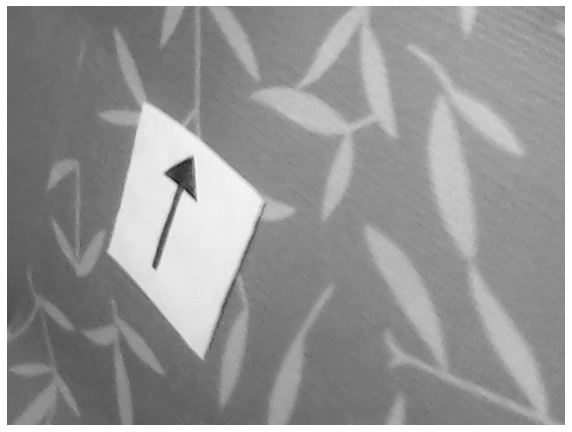

In [20]:
import numpy as np
import cv2
import time
import os
import math
import sys
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
img = cv2.imread ("../data/imgs/arrow/vlcsnap-2020-10-21-18h01m22s212.png", cv2.IMREAD_COLOR)
img = cv2.cvtColor (img, cv2.COLOR_BGR2GRAY)
plt.imshow (img, cmap = 'gray')
plt.axis ('off')
plt.show ()

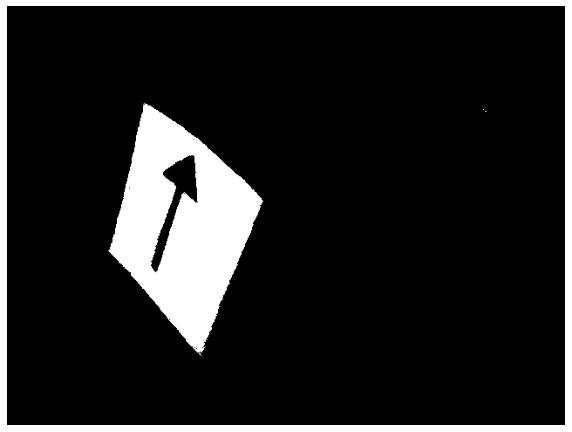

In [21]:
# Mask
low_th  = (210) #, 200, 200)
high_th = (255) #, 255, 255)

mask = cv2.inRange (img, low_th, high_th)

plt.imshow (mask, cmap = 'gray')
plt.axis ('off')
plt.show ()